In [0]:
import time
import os
import os.path
from osgeo import gdal, ogr, osr
from scipy import ndimage
from scipy import misc
from io import StringIO
gdal.UseExceptions()
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import urllib
import pandas as pd
import numpy as np 


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Extract Deep Features of Daytime Images with CNN


In [0]:
#Change to Daytime Analysis folder
os.chdir('/content/drive/My Drive/Thesis/daytime_analysis')


In [4]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [7]:
from keras.applications.vgg16 import VGG16
import numpy as np
from keras.preprocessing import image
from keras.models import Sequential
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.layers.convolutional import Convolution2D, AveragePooling2D
from keras.optimizers import SGD
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Dropout
from multiprocessing import Pool
import os
import time
import pandas as pd
import numpy as np
from keras.models import Model
import pickle 
import keras

with open('/content/drive/My Drive/Thesis/daytime_analysis/images_name_dict', 'rb') as fp:
    images_name_dict = pickle.load(fp)

def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx


npzfile = np.load('/content/drive/My Drive/Thesis/nightlight.npz')
print(npzfile.files)
top_left_x_coords = npzfile['top_left_x_coords']
top_left_y_coords = npzfile['top_left_y_coords']
bands_data = npzfile['bands_data']

['top_left_x_coords', 'top_left_y_coords', 'bands_data']


In [8]:
# get image featuers
base_model = VGG16(weights='imagenet')
model = Model(input=base_model.input, output=base_model.get_layer('fc2').output,
                                         backend=keras.backend,
                                          layers=keras.layers,
                                          models=keras.models,
                                          utils=keras.utils)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(backend=<module 'k..., layers=<module 'k..., models=<module 'k..., utils=<module 'k..., inputs=Tensor("in..., outputs=Tensor("fc...)`
  import sys


TypeError: ignored

In [0]:
import os
os.mkdir('/content/google_images')
!cp /content/drive/My\ Drive/Thesis/google_images.zip /content/google_images

In [0]:
os.chdir('/content/google_images') 

In [0]:
!unzip -qq /content/google_images/google_images.zip

In [0]:
!rm /content/google_images/google_images.zip

In [0]:
def get_input_feature(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    # img = image.load_img(img_path)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features[0]

In [0]:
#path that contains folder you want to copy
%cd /gdrive/My Drive/...
%cp -av YOUR_FOLDER NEW_FOLDER_COPY

# https://www.kaggle.com/c/bengaliai-cv19/discussion/130895

In [0]:
def get_daytime_feature(sample):
    idx, wealth, x, y = sample
    print(idx)
    lon_idx, lat_idx = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    left_idx = lon_idx - 5
    right_idx = lon_idx + 4
    up_idx = lat_idx - 5
    low_idx = lat_idx + 4
    features_100 = []
    for i in range(left_idx, right_idx + 1):
        for j in range(up_idx, low_idx + 1):
            file_name = str(i) + '_' + str(j) + '.jpg'
            if file_name in images_name_dict:
                luminosity = images_name_dict[file_name]
                feature = get_input_feature('/content/google_images/google_images/' + str(luminosity) + '/' + file_name)
                features_100.append(feature)
            else: 
                continue
    if len(features_100) == 0:
        print('nononono: ' + str(idx))
        return np.asarray([np.nan] * 4096 + [wealth]).tolist()
    else:
        features_100 = np.asarray(features_100)
        return np.append(np.mean(features_100, axis=0), wealth).tolist()


In [0]:
dhs_path = '/content/drive/My Drive/Thesis/DHS_Data/bangladesh_cluster_avg_asset_2013_updated_new.csv'

In [0]:
clusters = pd.read_csv(dhs_path)
clusters['feature'] = clusters.apply(lambda x: get_daytime_feature([x['cluster'], x['wlthindf'], x['longitude'], x['latitude']]), axis=1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [0]:
clusters.head()

,Unnamed: 0,cluster,wlthindf,URBAN_RURA,latitude,longitude
0,0,1,-0.831240,R,21.965697,90.126312
1,1,2,-0.739180,R,22.221232,90.348908
2,2,3,-0.786210,R,22.191484,90.212539
3,3,4,-0.447090,R,22.185481,90.167023
4,4,5,-0.687435,R,22.311173,90.149822


In [0]:
#clusters = pd.read_csv(dhs_path)
#clusters['feature'] = clusters.apply(lambda x: get_daytime_feature([x['cluster'], x['wlthindf'], x['longitude'], x['latitude']]), axis=1)

data_all = clusters['feature']
data_all = np.asarray([i for i in data_all])
data_all = data_all[~np.isnan(data_all).any(axis=1)]

np.savetxt('/content/drive/My Drive/Thesis/daytime_analysis/google_image_features_cnn.csv', data_all)

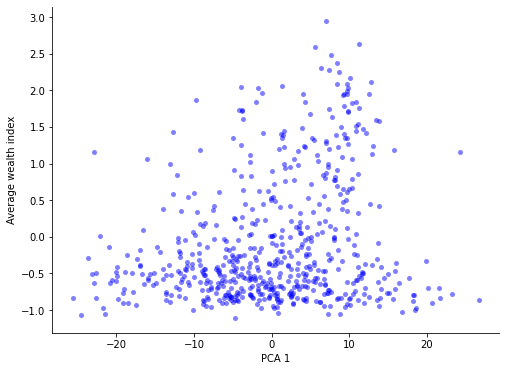

In [0]:
from sklearn.decomposition import PCA

data_all = np.loadtxt('/content/drive/My Drive/Thesis/daytime_analysis/google_image_features_cnn.csv')
x = data_all[:, :-1]
y = data_all[:, -1]
pca = PCA(n_components=1)
pca.fit(x)
proj = pca.transform(x)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(proj[:,0], y, 'o', c='blue', markersize=5, markeredgecolor='none', alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('Average wealth index')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


In [0]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA

data_all = np.loadtxt('/content/drive/My Drive/Thesis/daytime_analysis/google_image_features_cnn.csv')

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Ridge(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        train_x = train[:, :-1]
        train_y = train[:, -1]
        test_x = test[:, :-1]
        test_y = test[:, -1]
        # reduce dimensions to avoid overfitting
        pca = PCA(n_components=100)
        pca.fit(train_x)
        train_x = pca.transform(train_x)
        test_x = pca.transform(test_x)
        reg.fit(train_x, train_y)
        s = reg.score(test_x, test_y)
        scores.append(s)
    final.append(np.mean(scores))

print('R^2 of the best model: {:.3f}'.format(np.max(final)))


R^2 of the best model: 0.517


In [0]:
from sklearn.linear_model import Lasso

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Lasso(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        train_x = train[:, :-1]
        train_y = train[:, -1]
        test_x = test[:, :-1]
        test_y = test[:, -1]
        # reduce dimensions to avoid overfitting
        pca = PCA(n_components=100)
        pca.fit(train_x)
        train_x = pca.transform(train_x)
        test_x = pca.transform(test_x)
        reg.fit(train_x, train_y)
        s = reg.score(test_x, test_y)
        scores.append(s)
    final.append(np.mean(scores))

print('R^2 of the best model: {:.3f}'.format(np.max(final)))


R^2 of the best model: 0.429


In [0]:
from sklearn.linear_model import ElasticNet

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = ElasticNet(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        train_x = train[:, :-1]
        train_y = train[:, -1]
        test_x = test[:, :-1]
        test_y = test[:, -1]
        # reduce dimensions to avoid overfitting
        pca = PCA(n_components=100)
        pca.fit(train_x)
        train_x = pca.transform(train_x)
        test_x = pca.transform(test_x)
        reg.fit(train_x, train_y)
        s = reg.score(test_x, test_y)
        scores.append(s)
    final.append(np.mean(scores))

print('R^2 of the best model: {:.3f}'.format(np.max(final)))


R^2 of the best model: 0.463


In [0]:
from sklearn.ensemble import RandomForestRegressor

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = RandomForestRegressor()
        train = data_all[train_index]
        test = data_all[test_index]
        train_x = train[:, :-1]
        train_y = train[:, -1]
        test_x = test[:, :-1]
        test_y = test[:, -1]
        # reduce dimensions to avoid overfitting
        pca = PCA(n_components=100)
        pca.fit(train_x)
        train_x = pca.transform(train_x)
        test_x = pca.transform(test_x)
        reg.fit(train_x, train_y)
        s = reg.score(test_x, test_y)
        scores.append(s)
    final.append(np.mean(scores))

print('R^2 of the best model: {:.3f}'.format(np.max(final)))


R^2 of the best model: 0.422


In [0]:
class Metrics(object):
  """Performance metrics for regressor."""

  def __init__(self, y_true, predictions):
    self.y_true = y_true
    self.predictions = predictions
    self.residuals = self.y_true - self.predictions
    self.rmse = self.calculate_rmse(self.residuals)
    self.mae = self.calculate_mae(self.residuals)
    self.malr = self.calculate_malr(self.y_true, self.predictions)

  def calculate_rmse(self, residuals):
    """Root mean squared error."""
    return np.sqrt(np.mean(np.square(residuals)))

  def calculate_mae(self, residuals):
    """Mean absolute error."""
    return np.mean(np.abs(residuals))

  def calculate_malr(self, y_true, predictions):
    """Mean absolute log ratio."""
    return np.mean(np.abs(np.log(1 + predictions) - np.log(1 + y_true)))

  def report(self, name=None):
    if name is not None:
      print_string = '{} results'.format(name)
      print(print_string)
      print('~' * len(print_string))
    print('RMSE: {:2.3f}\nMAE: {:2.3f}\nMALR: {:2.3f}'.format(
        self.rmse, self.mae, self.malr))


In [0]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


# data_all = data_all.values


kf = KFold(n_splits=10, shuffle=True)
scores = []
for train_index, test_index in kf.split(data_all):
  train = data_all[train_index]
  test = data_all[test_index]
  xgb = XGBRegressor()
  xgb.fit(train[:, :-1], train[:, -1])
  xgb_pred = xgb.predict(test[:, :-1])
  XGBoost_metrics = Metrics(test[:, -1], xgb_pred)
#  XGBoost_metrics.report("XGBoost")

# Look at the R^2 scores on train and test
print("R2 train: ", xgb.score(train[:, :-1], train[:, -1]))
print("R2 test: ", xgb.score(test[:, :-1], test[:, -1]))


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[23:49:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


[23:49:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:49:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:50:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:50:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:50:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:50:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:51:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

# Daytime and Nighttime Model

In [0]:
#Load data for deep daytime satellite image
daytime = np.loadtxt('/content/drive/My Drive/Thesis/daytime_analysis/google_image_features_cnn.csv')
print("Shape of daytime dataframe: {}".format(daytime.shape))

#Load data for nighttime
ntl_summary_stats_file = '/content/drive/My Drive/Thesis/DHS_nightlights.csv'
ntl_summary_stats = pd.read_csv(ntl_summary_stats_file)
print("Shape of nighttime dataframe: {}".format(ntl_summary_stats.shape))

#DHS data
dhs_indicators_file = '/content/drive/My Drive/Thesis/DHS_Data/bangladesh_cluster_avg_asset_2013_version_2.csv'
dhs_indicators = pd.read_csv(dhs_indicators_file)
print("Shape of DHS dataframe: {}".format(dhs_indicators.shape))

Shape of daytime dataframe: (599, 4097)
Shape of nighttime dataframe: (599, 7)
Shape of DHS dataframe: (599, 6)


In [0]:
#convert daytime to pandas dataframe
daytime_df = pd.DataFrame(daytime)
daytime_df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
594,1.290671,1.342996,0.233173,0.382700,1.909137,0.025976,0.244432,0.002636,0.703454,0.061602,0.000519,0.756026,0.614320,1.854125,1.169775,0.218761,1.243387,1.197937,0.099913,0.093743,2.067238,0.048795,0.172429,1.025960,0.070175,2.150667,0.049304,1.253369,0.0,0.336325,0.983376,0.204441,1.673776,0.026108,2.230948,0.000000,0.002136,0.162737,0.037160,0.621838,...,0.053810,0.418557,0.0,0.0,0.070769,0.031809,1.043135,0.011278,0.000000,0.066012,0.001932,0.000000,0.097682,1.053747,0.001898,0.005273,0.643105,0.219108,0.146259,0.000000,1.000614,0.173276,0.939399,0.171832,1.280732,0.106531,0.109999,0.255092,0.080998,0.258878,0.073335,0.497540,0.240732,0.281827,2.622488,0.744988,0.017630,0.260064,0.151812,1.757480
595,1.213175,1.278480,0.212103,0.389614,1.805405,0.015586,0.213118,0.002636,0.685829,0.062244,0.000519,0.870940,0.509279,1.919259,1.256548,0.274368,1.083661,1.227699,0.118905,0.102253,2.163517,0.056426,0.182383,1.020985,0.079149,1.925148,0.018929,1.318524,0.0,0.240374,0.924813,0.205726,1.751662,0.026747,1.731431,0.000000,0.002136,0.144089,0.066092,0.635610,...,0.065959,0.422031,0.0,0.0,0.091917,0.031411,1.110399,0.011278,0.000000,0.074138,0.001104,0.000000,0.145957,0.904805,0.001898,0.005273,0.630757,0.194533,0.154491,0.010165,1.217727,0.149192,0.809942,0.275401,0.996889,0.138421,0.105966,0.332458,0.082775,0.315854,0.093796,0.550754,0.213034,0.181176,2.580640,0.725348,0.022563,0.294206,0.113670,1.591590
596,1.664237,1.399065,0.277186,0.515453,2.120210,0.022946,0.281712,0.002636,0.878778,0.052050,0.000519,1.122528,0.837917,2.063519,1.462170,0.102263,1.032012,1.358659,0.077872,0.161928,1.871189,0.040940,0.170769,1.284702,0.037950,2.712585,0.018929,1.083252,0.0,0.394476,1.160589,0.150436,1.313339,0.008513,2.103436,0.001283,0.002136,0.166323,0.047011,0.512267,...,0.030013,0.278129,0.0,0.0,0.054377,0.023029,1.097719,0.007971,0.000000,0.078924,0.001104,0.000000,0.070646,0.962413,0.001898,0.005273,0.586084,0.160912,0.139701,0.010165,1.006383,0.164869,0.889528,0.275251,1.390465,0.096383,0.105884,0.193035,0.083830,0.143298,0.042986,0.396986,0.217210,0.271480,3.077972,0.800003,0.017073,0.252175,0.236873,2.281590
597,1.703871,1.330565,0.224491,0.555194,2.028465,0.016464,0.251602,0.003387,1.146762,0.033769,0.000519,1.419528,0.948135,2.207538,1.492052,0.233728,0.841513,1.334494,0.120146,0.207312,1.784462,0.038548,0.196913,1.289620,0.071382,2.674753,0.012366,1.127786,0.0,0.265412,1.242343,0.131819,0.950331,0.013495,1.508145,0.001283,0.000000,0.147551,0.032857,0.437229,...,0.055216,0.170555,0.0,0.0,0.088332,0.021698,1.012389,0.001335,0.001078,0.117042,0.000462,0.000000,0.105760,0.651003,0.018841,0.000000,0.318904,0.149266,0.136019,0.010165,1.284107,0.081188,0.523482,0.382671,1.211034,0.179737,0.108832,0.385102,0.102342,0.193045,0.078457,0.388240,0.109472,0.105556,3.170529,0.631181,0.029941,0.253900,0.275757,-0.042325
598,2.010448,1.546573,0.308765,0.586065,2.315336,0.023376,0.297734,0.004266,0.972155,0.051161,0.000519,1.340793,1.156493,2.125550,1.598326,0.053211,0.884735,1.424071,0.049512,0.211994,1.844249,0.006247,0.206436,1.311936,0.026356,3.061527,0.018929,0.877353,0.0,0.438172,1.316710,0.140677,1.004601,0.002124,2.080435,0.001283,0.000171,0.174408,0.032857,0.489040,...,0.020840,0.184196,0.0,0.0,0.033519,0.024679,1.164173,0.001335,0.001078,0.081953,0.001104,0.005947,0.038445,0.927312,0.000895,0.000000,0.442917,0.138947,0.123420,0.016900,0.931036,0.141682,0.739294,0.282066,1.522687,0.120393,0.101413,0.168099,0.075107,0.101616,0.017794,0.298964,0.181846,0.216484,3.371163,0.776986,0.047192,0.181223,0.252230,1.242605


In [0]:
daytime_df['cluster'] = daytime_df.index
daytime_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096,cluster
0,2.878998,1.329168,0.161021,0.125014,2.828060,0.020644,0.032862,0.001189,1.384136,0.019441,0.000000,1.691049,2.054427,2.565041,0.716215,0.031667,0.776966,1.037366,0.423272,0.424601,1.077813,0.000000,0.361915,1.107124,0.000000,4.055763,0.010296,1.314169,0.002272,0.143387,0.866563,0.255373,0.030568,0.032327,2.324373,0.022384,0.068766,0.274288,0.058056,0.707191,...,0.358056,0.0,0.000000,0.133420,0.118728,0.879106,0.000000,0.000000,0.909384,0.000000,0.009588,0.018068,0.584988,0.118746,0.000000,0.012243,0.955132,0.084949,0.005367,0.334328,0.065909,0.399838,0.359364,3.165095,0.301046,0.090921,0.491110,0.128437,0.013149,0.003739,0.599684,0.027007,0.998664,2.821125,0.878972,0.087971,0.189300,0.980785,-0.831240,0
1,3.373485,0.496236,0.158112,0.135282,2.079401,0.050085,0.138509,0.000000,1.860647,0.008386,0.000000,1.984433,2.684054,3.796033,0.334375,0.006304,0.809719,1.813728,0.890192,1.884948,1.081008,0.005032,0.381700,1.855847,0.009397,4.264237,0.004664,0.794688,0.004595,0.106387,1.661820,0.084626,0.000000,0.006482,1.928692,0.065101,0.147640,0.282335,0.239189,0.847348,...,0.078198,0.0,0.000000,0.113447,0.063581,1.350038,0.000000,0.007203,1.200330,0.000000,0.000000,0.022812,0.702261,0.253239,0.000000,0.014980,1.393647,0.003570,0.005691,0.379971,0.108724,0.539400,0.296566,2.726270,0.083071,0.009102,0.051620,0.149705,0.000000,0.000000,0.682016,0.155553,0.894432,2.757739,0.673704,0.275677,0.131902,1.675853,-0.739180,1
2,1.702980,0.547667,0.159089,0.134749,2.436623,0.048665,0.463020,0.000000,1.496138,0.050759,0.000000,1.821219,1.314518,1.971779,1.032771,0.061291,0.749488,2.022660,0.394493,0.300486,2.310588,0.093115,0.791870,1.158460,0.007518,3.194735,0.000000,1.687372,0.011666,0.113900,1.608095,0.258351,0.024142,0.058797,1.502094,0.177154,0.150541,0.239933,0.045277,1.354071,...,0.450991,0.0,0.005267,0.222313,0.078706,1.657473,0.014797,0.003369,0.696015,0.008829,0.005028,0.128195,1.321091,0.108262,0.008459,0.054078,0.274712,0.082658,0.012515,0.759579,0.209575,0.394156,0.485424,2.285892,0.202556,0.033975,0.328689,0.216203,0.040890,0.103809,1.129966,0.087070,0.371983,2.949382,1.070461,0.392354,0.308145,0.705501,-0.786210,2
3,2.163246,1.206992,0.163880,0.252487,2.672118,0.018356,0.507327,0.002756,1.648438,0.000000,0.001553,1.523501,1.750185,2.223530,1.366812,0.040510,0.772889,1.288658,0.329589,0.471390,2.687568,0.101083,0.577124,0.830511,0.000000,3.520612,0.007863,1.706736,0.005112,0.175209,1.745934,0.133480,0.022079,0.011199,2.190662,0.072306,0.133072,0.226454,0.007559,1.412592,...,0.557176,0.0,0.000000,0.014880,0.000000,1.706560,0.002565,0.007964,0.204303,0.000000,0.005028,0.022938,1.309194,0.000000,0.005865,0.002037,0.283719,0.047029,0.011242,0.715230,0.115861,0.405255,0.167983,2.692277,0.160140,0.018882,0.146738,0.108441,0.058254,0.000000,0.829935,0.074928,0.200240,3.232934,1.254800,0.252297,0.313121,0.569507,-0.447090,3
4,2.093141,0.822157,0.126388,0.111475,2.873505,0.023679,0.291447,0.000000,1.237704,0.114842,0.000000,1.292678,2.230158,2.322423,1.206988,0.009452,0.654845,2.048600,0.290508,0.798551,2.502542,0.009821,0.264866,1.010887,0.002008,3.674431,0.005885,2.064326,0.000000,0.332223,2.151988,0.165172,0.009030,0.063368,1.771359,0.030752,0.055945,0.381560,0.044878,2.053910,...,0.351224,0.0,0.001883,0.105338,0.118566,1.081463,0.004827,0.000000,0.787610,0.000000,0.001160,0.055229,1.341312,0.081887,0.000000,0.036064,0.613460,0.023606,0.004575,0.878791,0.096632,0.613624,0.449971,2.599991,0.193163,0.060863,0.075389,0.150256,0.046882,0.007581,0.560687,0.038819,0.719127,3.324731,1.172433,0.423795,0.113245,1.372420,-0.687435,4


In [0]:
day_night_df = daytime_df.merge(ntl_summary_stats, left_on='cluster', right_on = 'id')
day_night_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096,cluster,id,max_,min_,mean_,median_,std_,wealth
0,3.373485,0.496236,0.158112,0.135282,2.079401,0.050085,0.138509,0.000000,1.860647,0.008386,0.000000,1.984433,2.684054,3.796033,0.334375,0.006304,0.809719,1.813728,0.890192,1.884948,1.081008,0.005032,0.381700,1.855847,0.009397,4.264237,0.004664,0.794688,0.004595,0.106387,1.661820,0.084626,0.000000,0.006482,1.928692,0.065101,0.147640,0.282335,0.239189,0.847348,...,0.007203,1.200330,0.000000,0.000000,0.022812,0.702261,0.253239,0.000000,0.014980,1.393647,0.003570,0.005691,0.379971,0.108724,0.539400,0.296566,2.726270,0.083071,0.009102,0.051620,0.149705,0.000000,0.000000,0.682016,0.155553,0.894432,2.757739,0.673704,0.275677,0.131902,1.675853,-0.739180,1,1.0,0.0,0.0,0.00,0.0,0.000000,-0.831240
1,1.702980,0.547667,0.159089,0.134749,2.436623,0.048665,0.463020,0.000000,1.496138,0.050759,0.000000,1.821219,1.314518,1.971779,1.032771,0.061291,0.749488,2.022660,0.394493,0.300486,2.310588,0.093115,0.791870,1.158460,0.007518,3.194735,0.000000,1.687372,0.011666,0.113900,1.608095,0.258351,0.024142,0.058797,1.502094,0.177154,0.150541,0.239933,0.045277,1.354071,...,0.003369,0.696015,0.008829,0.005028,0.128195,1.321091,0.108262,0.008459,0.054078,0.274712,0.082658,0.012515,0.759579,0.209575,0.394156,0.485424,2.285892,0.202556,0.033975,0.328689,0.216203,0.040890,0.103809,1.129966,0.087070,0.371983,2.949382,1.070461,0.392354,0.308145,0.705501,-0.786210,2,2.0,0.0,0.0,0.00,0.0,0.000000,-0.739180
2,2.163246,1.206992,0.163880,0.252487,2.672118,0.018356,0.507327,0.002756,1.648438,0.000000,0.001553,1.523501,1.750185,2.223530,1.366812,0.040510,0.772889,1.288658,0.329589,0.471390,2.687568,0.101083,0.577124,0.830511,0.000000,3.520612,0.007863,1.706736,0.005112,0.175209,1.745934,0.133480,0.022079,0.011199,2.190662,0.072306,0.133072,0.226454,0.007559,1.412592,...,0.007964,0.204303,0.000000,0.005028,0.022938,1.309194,0.000000,0.005865,0.002037,0.283719,0.047029,0.011242,0.715230,0.115861,0.405255,0.167983,2.692277,0.160140,0.018882,0.146738,0.108441,0.058254,0.000000,0.829935,0.074928,0.200240,3.232934,1.254800,0.252297,0.313121,0.569507,-0.447090,3,3.0,0.0,0.0,0.00,0.0,0.000000,-0.786210
3,2.093141,0.822157,0.126388,0.111475,2.873505,0.023679,0.291447,0.000000,1.237704,0.114842,0.000000,1.292678,2.230158,2.322423,1.206988,0.009452,0.654845,2.048600,0.290508,0.798551,2.502542,0.009821,0.264866,1.010887,0.002008,3.674431,0.005885,2.064326,0.000000,0.332223,2.151988,0.165172,0.009030,0.063368,1.771359,0.030752,0.055945,0.381560,0.044878,2.053910,...,0.000000,0.787610,0.000000,0.001160,0.055229,1.341312,0.081887,0.000000,0.036064,0.613460,0.023606,0.004575,0.878791,0.096632,0.613624,0.449971,2.599991,0.193163,0.060863,0.075389,0.150256,0.046882,0.007581,0.560687,0.038819,0.719127,3.324731,1.172433,0.423795,0.113245,1.372420,-0.687435,4,4.0,13.0,0.0,1.31,0.0,3.148635,-0.447090
4,1.373009,0.600921,0.289831,0.120488,1.847874,0.027131,0.323691,0.007558,1.123723,0.045872,0.000000,1.664369,0.749161,1.724076,0.837250,0.012750,1.465053,2.337451,0.151290,0.457796,1.506538,0.067847,0.658609,1.577530,0.000000,2.670577,0.010113,0.940644,0.030090,0.012501,1.041732,0.030618,0.000677,0.000535,1.808819,0.108509,0.059274,0.297077,0.020688,0.637514,...,0.011765,0.497544,0.000000,0.000000,0.035193,1.513333,0.046742,0.000000,0.056202,0.194710,0.009798,0.001132,1.173426,0.359200,0.751730,0.390945,2.229216,0.316504,0.099091,0.350951,0.149129,0.061954,0.051025,0.506924,0.016694,0.055643,2.639214,0.514255,0.217420,0.123877,0.925091,-0.720975,5,5.0,0.0,0.0,0.00,0.0,0.000000,-0.687435


In [0]:
#Drop unneeded columns
day_night_df = day_night_df.drop(['cluster', 'id', ], axis=1)

In [0]:
#Ridge regression model
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

data_all = day_night_df
#data_all = data_all.as_matrix()
data_all = data_all.values
np.random.seed(123)

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Ridge(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the best model: {np.max(final)}')

R^2 of the best model: 0.6153174750423785


In [0]:
from sklearn.linear_model import Lasso

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Lasso(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the best model: {np.max(final)}')

R^2 of the best model: 0.5968901779279504


In [0]:
from sklearn.linear_model import ElasticNet

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = ElasticNet(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the best model: {np.max(final)}')


R^2 of the best model: 0.6072892660351349


In [0]:
from sklearn.ensemble import RandomForestRegressor

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = RandomForestRegressor()
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the best model: {np.max(final)}')


R^2 of the best model: 0.599507874668809


In [0]:
class Metrics(object):
  """Performance metrics for regressor."""

  def __init__(self, y_true, predictions):
    self.y_true = y_true
    self.predictions = predictions
    self.residuals = self.y_true - self.predictions
    self.rmse = self.calculate_rmse(self.residuals)
    self.mae = self.calculate_mae(self.residuals)
    self.malr = self.calculate_malr(self.y_true, self.predictions)

  def calculate_rmse(self, residuals):
    """Root mean squared error."""
    return np.sqrt(np.mean(np.square(residuals)))

  def calculate_mae(self, residuals):
    """Mean absolute error."""
    return np.mean(np.abs(residuals))

  def calculate_malr(self, y_true, predictions):
    """Mean absolute log ratio."""
    return np.mean(np.abs(np.log(1 + predictions) - np.log(1 + y_true)))

  def report(self, name=None):
    if name is not None:
      print_string = '{} results'.format(name)
      print(print_string)
      print('~' * len(print_string))
    print('RMSE: {:2.3f}\nMAE: {:2.3f}\nMALR: {:2.3f}'.format(
        self.rmse, self.mae, self.malr))


In [0]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


kf = KFold(n_splits=10, shuffle=True)
scores = []
for train_index, test_index in kf.split(data_all):
  train = data_all[train_index]
  test = data_all[test_index]
  xgb = XGBRegressor()
  xgb.fit(train[:, :-1], train[:, -1])
  xgb_pred = xgb.predict(test[:, :-1])
  XGBoost_metrics = Metrics(test[:, -1], xgb_pred)
#  XGBoost_metrics.report("XGBoost")

# Look at the R^2 scores on train and test
print("R2 train: ", xgb.score(train[:, :-1], train[:, -1]))
print("R2 test: ", xgb.score(test[:, :-1], test[:, -1]))



/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[12:31:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


[12:31:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:31:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:31:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:32:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:32:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:32:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:32:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:33:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re